detect Fire from the images provided

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Sequential   # Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
from keras.layers import Dense    # the neurons in the dense layer get their source of input data from all the other neurons of the previous layer of the network
from keras.layers import Flatten    #converts the multi-dimensional arrays into flattened one-dimensional arrays or single-dimensional arrays
from keras.layers import Activation
from keras.layers import Dropout    # provide a rate that sets the frequency of which input units are randomly set to 0 (dropped out).
from keras.layers import BatchNormalization   #Layer that normalizes its inputs. maintains the mean output close to 0 and the output standard deviation close to 1.

from keras.layers import MaxPooling2D     # he window size which takes the maximum value into the pooling window which was 2*2. uses it to create a downsampled (pooled) feature map
from keras.layers import Convolution2D
from keras.layers import Conv2D   #a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.

from keras.preprocessing.image import ImageDataGenerator    #used to take the inputs of the original data and then transform it on a random basis
from keras.preprocessing.image import load_img

from keras import utils

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

import random
import os
import cv2

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels =3

In [12]:
filenames = os.listdir("/content/drive/MyDrive/data science /fire_dataset/Fire/Fire/Fire")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [13]:
filenames = os.listdir("/content/drive/MyDrive/data science /fire_dataset/Fire/Fire/Non Fire")
categories = []
new_rows_df=[]
for filename in filenames:
  category = filename.split('.')[0]
  new_rows_df.append({'filename': filename,'category': 0})


df = df.append(new_rows_df, ignore_index=True)

# new_rows_df = pd.DataFrame({
#     'filename': filenames,
#     'category': categories
# })

<ipython-input-13-97277473ec7c>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_rows_df, ignore_index=True)


In [14]:
df.sample(5)

,filename,category
92,33.jpg,1
60,146.jpg,1
186,43.jpg,0
70,138.jpg,1
140,134.jpg,0


<Axes: >

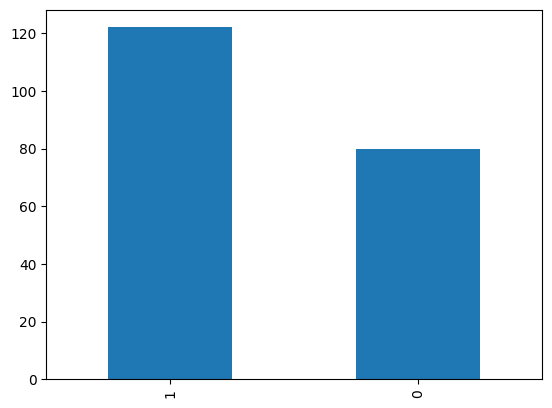

In [15]:
df['category'].value_counts().plot.bar()

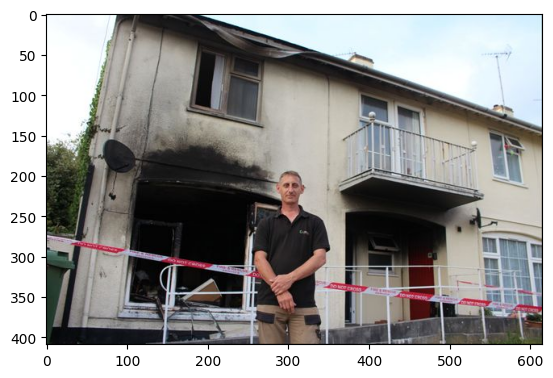

In [16]:
sample = random.choice(filenames)
img = load_img("/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original/"+sample)
plt.imshow(img)

In [17]:
model = Sequential()

model.add(Conv2D( 32, (3,3), activation='relu', input_shape=(Image_Width, Image_Height, Image_Channels)))
model.add( BatchNormalization())
model.add( MaxPooling2D(pool_size=(2,2 )))
model.add( Dropout(0.25))

model.add(Conv2D( 64, (3,3), activation='relu'))
model.add( BatchNormalization())
model.add( MaxPooling2D(pool_size=(2,2 )))
model.add( Dropout(0.25))

model.add(Conv2D( 128, (3,3), activation='relu'))
model.add( BatchNormalization())
model.add( MaxPooling2D(pool_size=(2,2 )))
model.add( Dropout(0.25))

In [18]:
model.add(Flatten( input_shape=[28,28] ))
model.add(Dense( 512, activation='relu' ))
model.add( BatchNormalization())
model.add( Dropout(0.5))
model.add(Dense( 2, activation='softmax' ))

In [19]:
model.compile( loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'] )

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [21]:
earlystop =EarlyStopping(patience=10)

learn_rate_reduction = ReduceLROnPlateau( monitor='val_accuracy', patience =2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learn_rate_reduction]

In [22]:
df['category'] = df['category'].replace({0:'not fire', 1:'fire'})

train_df, validate_df = train_test_split( df, test_size=0.2, random_state=42)
train_df = train_df.reset_index( drop=True)
validate_df = validate_df.reset_index( drop=True)

<Axes: >

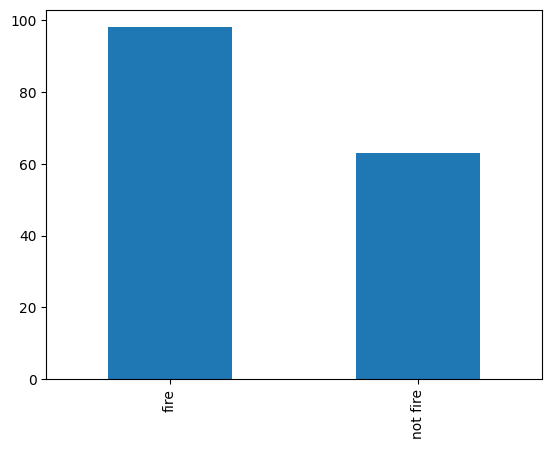

In [23]:
train_df['category'].value_counts().plot.bar()

<Axes: >

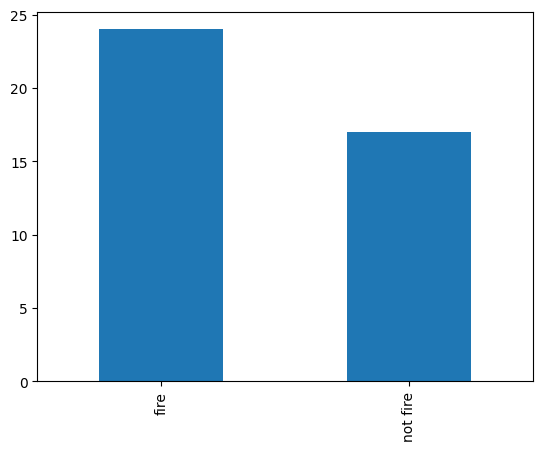

In [24]:
validate_df['category'].value_counts().plot.bar()

In [25]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

flow_from_dataframe: takes the Pandas DataFrame and the path to a directory and generates batches of augmented/normalized data.

In [26]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255 , shear_range=0.1,zoom_range=0.2, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df, "/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original", x_col="filename" , y_col="category" , target_size=Image_Size, batch_size=batch_size, class_mode='categorical')

Found 160 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [27]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(validate_df, "/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original", x_col="filename" , y_col="category" , target_size=Image_Size, batch_size=batch_size, class_mode='categorical')

Found 41 validated image filenames belonging to 2 classes.


In [28]:
ex_df = train_df.sample(n=1).reset_index(drop=True)
ex_generator = train_datagen.flow_from_dataframe(ex_df, "/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original", x_col = 'filename',y_col ='category', target_size=Image_Size,class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


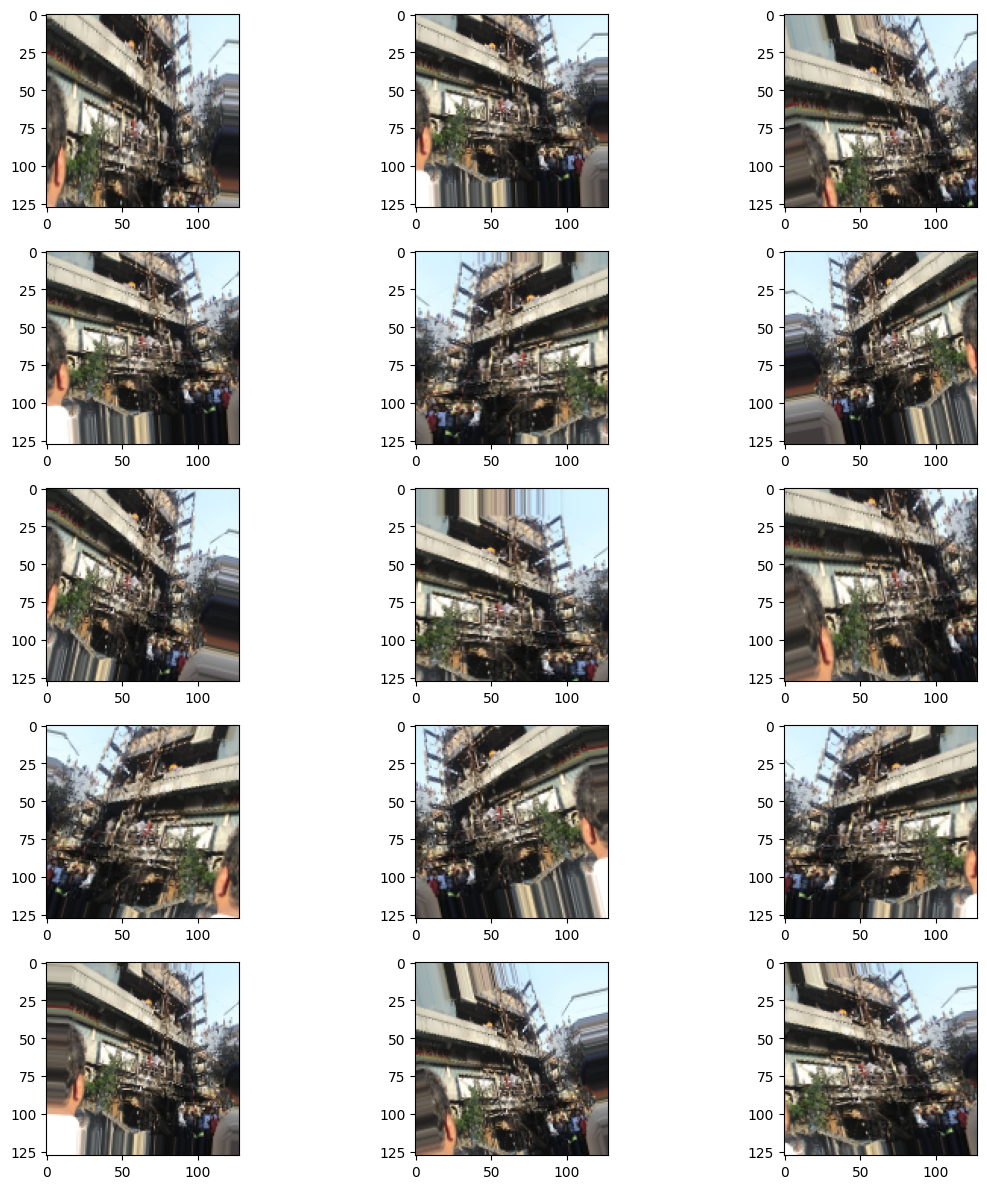

In [29]:
plt.figure(figsize=(12,12))
for i in range(0,15):
  plt.subplot(5,3,i+1)
  for x_batch, y_batch in ex_generator:
    img = x_batch[0]
    plt.imshow(img)
    break
plt.tight_layout()
plt.show()

In [30]:
Fast_Run = False
epochs = 3 if Fast_Run else 50
history = model.fit( train_generator, epochs=3, validation_data=validation_generator, validation_steps=total_validate//batch_size, steps_per_epoch=total_train//batch_size, callbacks=callbacks )
model.save('model.h5')

Epoch 1/3
10/10 [==============================] - 80s 8s/step - loss: 1.8483 - accuracy: 0.5862 - val_loss: 1.4952 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/3
10/10 [==============================] - 11s 1s/step - loss: 1.1015 - accuracy: 0.6345 - val_loss: 4.0103 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/3
10/10 [==============================] - 16s 2s/step - loss: 0.9506 - accuracy: 0.6933 - val_loss: 6.9805 - val_accuracy: 0.5333 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


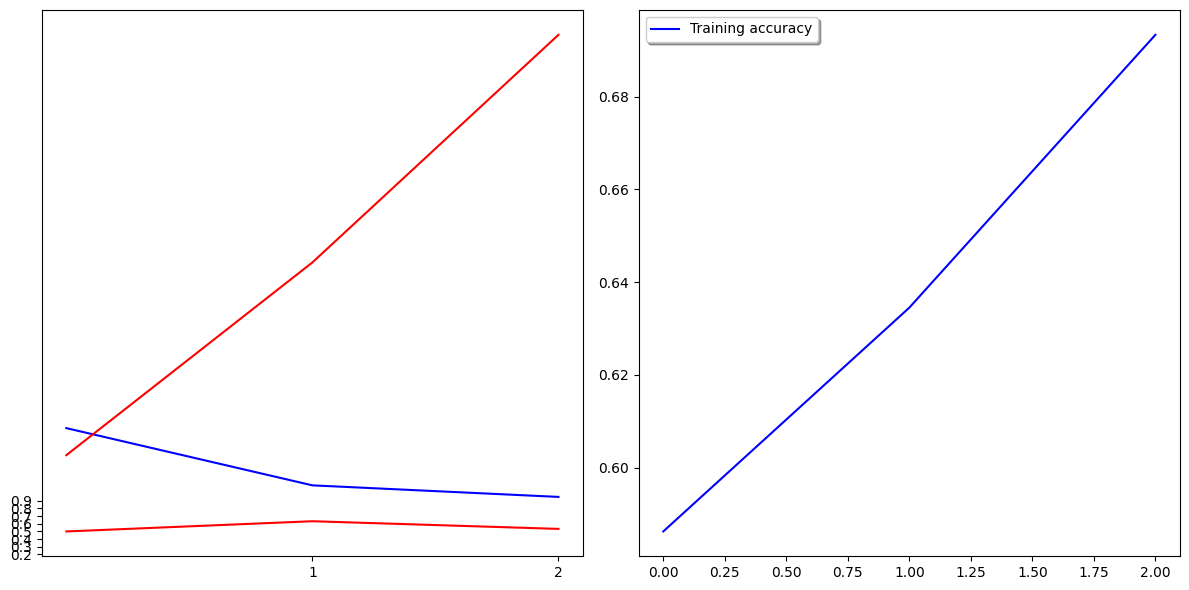

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(history.history['loss'], color='b', label='Training loss')
ax1.plot(history.history['val_loss'], color='r', label='validation_loss')
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0,1,0.1))

ax2.plot(history.history['accuracy'], color='b', label='Training accuracy')
ax1.plot(history.history['val_accuracy'], color='r', label='validation_accuracy')

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [32]:
from google.colab.patches import cv2_imshow

for i in range(10):
  all_test_images = os.listdir( "/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original" )
  random_image = random.choice(all_test_images)
  img = cv2.imread(f'/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original/{random_image}')
  img = cv2.resize(img, (Image_Height, Image_Width))

  org= img.copy()
  img = img.reshape(1,128,128,3)

  pred = model.predict(img)
  print( ['not fire','fire'][int(pred[0][0])])
  # cv2.imshow('Live predictions', org)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

1/1 [==============================] - 0s 184ms/step
fire
1/1 [==============================] - 0s 37ms/step
fire
1/1 [==============================] - 0s 48ms/step
fire
1/1 [==============================] - 0s 41ms/step
fire
1/1 [==============================] - 0s 41ms/step
fire
1/1 [==============================] - 0s 38ms/step
fire
1/1 [==============================] - 0s 34ms/step
fire
1/1 [==============================] - 0s 34ms/step
fire
1/1 [==============================] - 0s 36ms/step
fire
1/1 [==============================] - 0s 33ms/step
fire


1/1 [==============================] - 0s 68ms/step
fire
1/1 [==============================] - 0s 79ms/step
fire
1/1 [==============================] - 0s 84ms/step
fire
1/1 [==============================] - 0s 126ms/step
fire
1/1 [==============================] - 0s 128ms/step
fire
1/1 [==============================] - 0s 82ms/step
fire
1/1 [==============================] - 0s 108ms/step
fire
1/1 [==============================] - 0s 108ms/step
fire
1/1 [==============================] - 0s 96ms/step
fire
1/1 [==============================] - 0s 51ms/step
fire


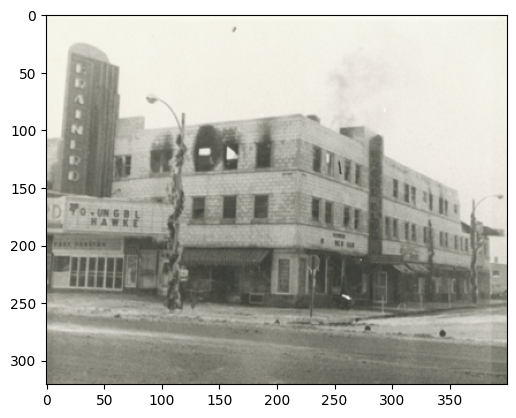

In [34]:
from google.colab.patches import cv2_imshow

for i in range(10):
  all_test_images = os.listdir( "/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original" )
  random_image = random.choice(all_test_images)
  sample_img = load_img("/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original/"+random_image)
  plt.imshow(sample_img)
  img = cv2.imread(f'/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original/{random_image}')
  img = cv2.resize(img, (Image_Height, Image_Width))

  org= img.copy()
  img = img.reshape(1,128,128,3)

  pred = model.predict(img)
  print( ['not fire','fire'][int(pred[0][0])])
  # cv2.imshow('Live predictions', org)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

1/1 [==============================] - 0s 37ms/step
fire
1/1 [==============================] - 0s 34ms/step
fire
1/1 [==============================] - 0s 45ms/step
fire
1/1 [==============================] - 0s 58ms/step
fire
1/1 [==============================] - 0s 140ms/step
fire
1/1 [==============================] - 0s 141ms/step
fire
1/1 [==============================] - 0s 88ms/step
fire
1/1 [==============================] - 0s 139ms/step
fire
1/1 [==============================] - 0s 108ms/step
fire
1/1 [==============================] - 0s 155ms/step
fire


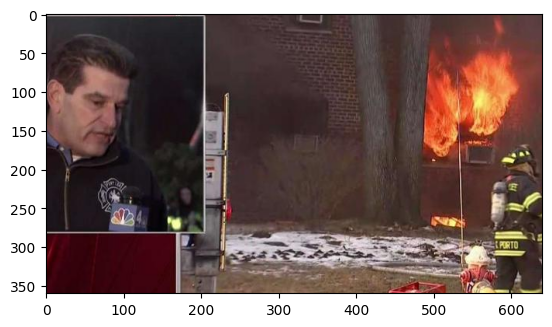

In [35]:
from google.colab.patches import cv2_imshow

for i in range(10):
  all_test_images = os.listdir( "/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original" )
  random_image = random.choice(all_test_images)
  sample_img = load_img("/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original/"+random_image)
  plt.imshow(sample_img)
  img = cv2.imread(f'/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original/{random_image}')
  img = cv2.resize(img, (Image_Height, Image_Width))

  org= img.copy()
  img = img.reshape(1,128,128,3)

  pred = model.predict(img)
  print( ['not fire','fire'][int(pred[0][0])])

1/1 [==============================] - 0s 38ms/step
fire
1/1 [==============================] - 0s 35ms/step
fire
1/1 [==============================] - 0s 37ms/step
fire
1/1 [==============================] - 0s 41ms/step
fire
1/1 [==============================] - 0s 34ms/step
fire
1/1 [==============================] - 0s 33ms/step
fire
1/1 [==============================] - 0s 39ms/step
fire
1/1 [==============================] - 0s 34ms/step
fire
1/1 [==============================] - 0s 34ms/step
fire
1/1 [==============================] - 0s 39ms/step
fire


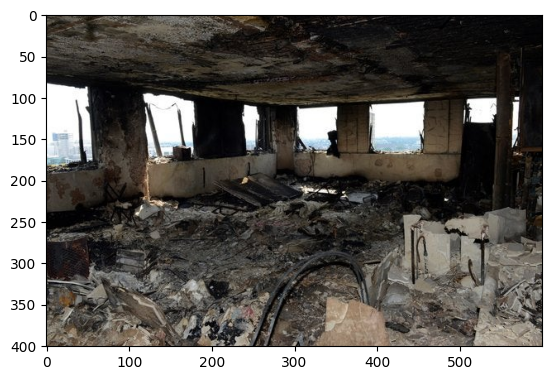

In [37]:
from google.colab.patches import cv2_imshow

for i in range(10):
  all_test_images = os.listdir( "/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original" )
  random_image = random.choice(all_test_images)
  sample_img = load_img("/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original/"+random_image)
  plt.imshow(sample_img)
  img = cv2.imread(f'/content/drive/MyDrive/data science /fire_dataset/Fire/Fire original/{random_image}')
  img = cv2.resize(img, (Image_Height, Image_Width))

  org= img.copy()
  img = img.reshape(1,128,128,3)

  pred = model.predict(img)
  print( ['not fire','fire'][int(pred[0][0])])